# Question 1

In [103]:
%%shell
jupyter nbconvert --to html ///content/DeepLearning_A03.ipynb

[NbConvertApp] Converting notebook ///content/DeepLearning_A03.ipynb to html
[NbConvertApp] Writing 5747105 bytes to ///content/DeepLearning_A03.html


In [3]:
import librosa
import numpy as np
import pandas as pd
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset
from torch.utils.data import SubsetRandomSampler
from tqdm import tqdm
from torch.autograd import Variable

In [12]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
                [transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
                 ])

dataset = CIFAR10(root='data/', download=True, transform=transform)
test_dataset = CIFAR10(root='data/', train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


In [56]:
print(type(dataset[0][0]))
print(type(dataset[0][1]))

<class 'torch.Tensor'>
<class 'int'>


In [57]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [64]:
torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [8]:
batch_size = 128

In [59]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


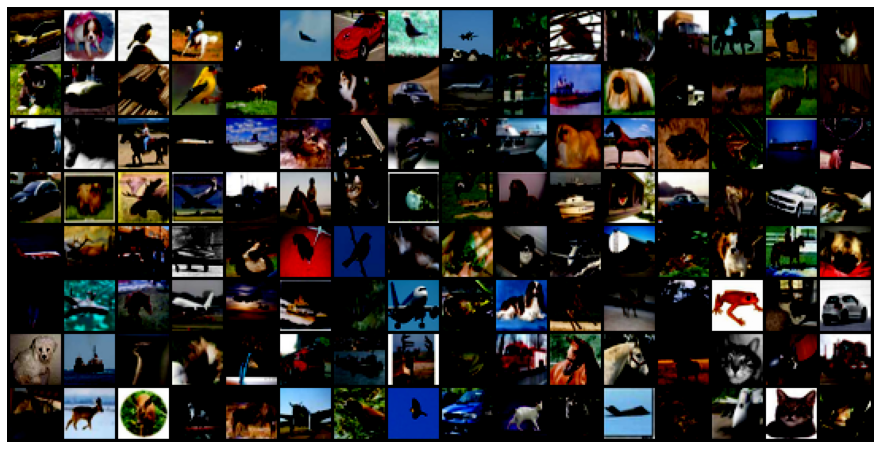

In [10]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [88]:
units = 1024
output1 = 513

class CNN2DNet(nn.Module):
    def __init__(self):
      super(CNN2DNet, self).__init__()

      self.layer1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = [5,5], stride = 1)
      self.maxpool1 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
      self.layer2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = [5,5], stride = 1)
      self.maxpool2 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
     
      self.flatten = nn.Flatten(1)
      self.layer4 = nn.Linear(250, 20)
      self.layer5 = nn.Linear(20, 10)
    
    def forward(self, network):
      #print("input shape:", network.shape)

      # print(network.shape,  "#")

      network = self.layer1(network)
      network = F.relu(network)
      network = self.maxpool1(network)

      network = self.layer2(network)
      network = F.relu(network)
      network = self.maxpool2(network)


      network = self.flatten(network)

      network = self.layer4(network)
      network = F.relu(network)


      network = self.layer5(network)

      #print("out net shape:", network.shape)

      return network

input1 = 1024

def weight_data(m):
  if isinstance(m, nn.Linear):
        weight = torch.empty(input1, 1)
        torch.nn.init.kaiming_normal_(m.weight, a=0, nonlinearity='relu', mode='fan_in',)

In [89]:

def train_neural_network_2(model,dataset_train,dataset_test,epochs,batch_size,
                         lr,activation,dev,assess):
  
  initial = 1
  stop = False
  valid_loss_final = []
  train_loss_final = []
  accuracy_final = []
  
  train_iterate = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_iterate = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  while ((initial <= epochs) and (stop == False)):
    train_loss = 0
    for img, label in train_iterate:

      img = img.to(dev)
      label = label.to(dev)
      
      optimizer.zero_grad()

      output_img = model.forward(img)
      loss = activation(output_img, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss_final.append(train_loss/len(train_iterate))
    
    bss = len(train_iterate.dataset)/len(train_iterate)

    # print(len(train_iterate), "!!")
    # print(len(train_iterate.dataset), "##")
    # print(len(train_iterate.dataset)/len(train_iterate), "$$")

    with torch.no_grad():
      test_loss = 0
      for val_img, val_label in val_iterate:

        val_img = val_img.to(dev)
        val_label = val_label.to(dev)
        output_img = model.forward(val_img)
        loss = activation(output_img, val_label)
        accuracy = assess(val_label.cpu().numpy(), output_img.argmax(1).cpu().numpy())
        test_loss += loss.item()

      accuracy_final.append(accuracy)
      valid_loss_final.append(test_loss/len(val_iterate))
    
      

    

    print("Current_epoch: " +str(initial))
    print('Accuracy: '+str(accuracy))
    
    initial += 1 

  return valid_loss_final, accuracy_final

In [90]:
from sklearn.metrics import accuracy_score

batch_size = 512
epochs = 200
activation = nn.CrossEntropyLoss()
lr = 0.001

model3 = CNN2DNet().to(dev)

model3.apply(weight_data)

valid_loss, accuracy_base = train_neural_network_2(model = model3, dataset_train = train_ds,
                dataset_test = val_ds, epochs = epochs,
                batch_size = batch_size, lr = lr,
                activation = activation, dev = dev, assess = accuracy_score)

Current_epoch: 1
Accuracy: 0.33849557522123896
Current_epoch: 2
Accuracy: 0.4336283185840708
Current_epoch: 3
Accuracy: 0.44579646017699115
Current_epoch: 4
Accuracy: 0.4690265486725664
Current_epoch: 5
Accuracy: 0.4856194690265487
Current_epoch: 6
Accuracy: 0.49004424778761063
Current_epoch: 7
Accuracy: 0.5265486725663717
Current_epoch: 8
Accuracy: 0.5165929203539823
Current_epoch: 9
Accuracy: 0.5254424778761062
Current_epoch: 10
Accuracy: 0.5387168141592921
Current_epoch: 11
Accuracy: 0.5442477876106194
Current_epoch: 12
Accuracy: 0.5519911504424779
Current_epoch: 13
Accuracy: 0.5597345132743363
Current_epoch: 14
Accuracy: 0.5575221238938053
Current_epoch: 15
Accuracy: 0.5741150442477876
Current_epoch: 16
Accuracy: 0.5752212389380531
Current_epoch: 17
Accuracy: 0.577433628318584
Current_epoch: 18
Accuracy: 0.5763274336283186
Current_epoch: 19
Accuracy: 0.5730088495575221
Current_epoch: 20
Accuracy: 0.5851769911504425
Current_epoch: 21
Accuracy: 0.5696902654867256
Current_epoch: 22
Ac

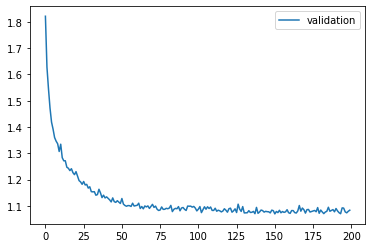

<Figure size 432x288 with 0 Axes>

In [91]:
plt.plot(valid_loss, label='validation')
plt.legend()
plt.show()
plt.savefig('Validation_before_aug.png')

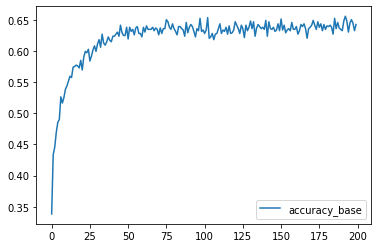

<Figure size 432x288 with 0 Axes>

In [92]:
plt.plot(accuracy_base, label='accuracy_base')
plt.legend()
plt.show()
plt.savefig('Accuracy_before_aug.png')

Files already downloaded and verified
images.shape: torch.Size([128, 3, 32, 32])
len train bright 45000


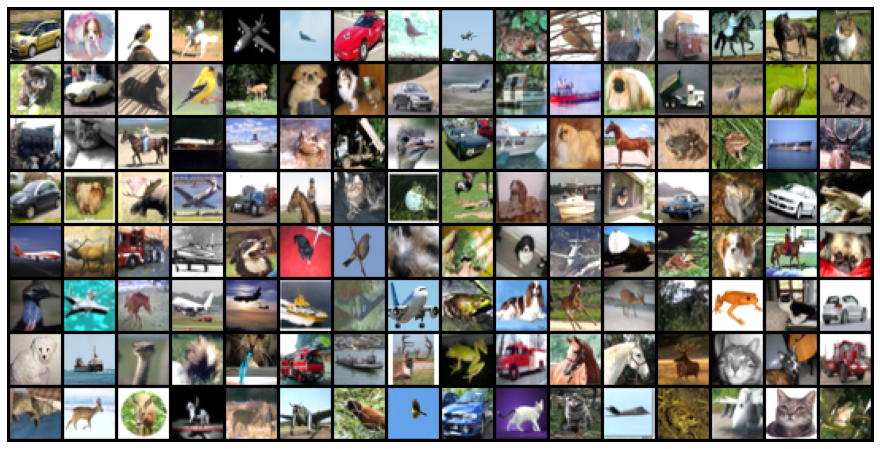

In [ ]:
transform = transforms.Compose([                                       
      transforms.ToTensor(),
  ])

dataset = CIFAR10(root='data/', download=True, transform = transform)
test_dataset = CIFAR10(root='data/', train=False, transform = transform)

torch.manual_seed(43)

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, pin_memory=True)

for img, _ in train_loader:
      img = np.minimum(1.1*img,1)
      print('images.shape:', img.shape)
      plt.figure(figsize=(16,8))
      plt.axis('off')
      plt.imshow(make_grid(img, nrow=16).permute((1, 2, 0)))
      break

print(train_ds, val_ds)
print("len train bright", len(train_ds))

Files already downloaded and verified
images.shape: torch.Size([128, 3, 32, 32])
len train bright 45000


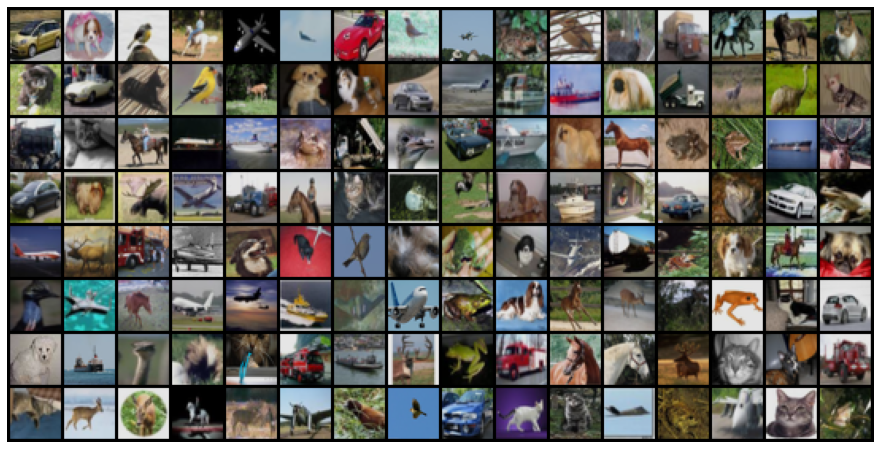

In [ ]:
transform = transforms.Compose([                                       
      transforms.ToTensor(),
  ])

dataset = CIFAR10(root='data/', download=True, transform = transform)
test_dataset = CIFAR10(root='data/', train=False, transform = transform)

torch.manual_seed(43)

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, pin_memory=True)

for img, _ in train_loader:
      img = np.minimum(0.9*img, 1)
      print('images.shape:', img.shape)
      plt.figure(figsize=(16,8))
      plt.axis('off')
      plt.imshow(make_grid(img, nrow=16).permute((1, 2, 0)))
      break

print(train_ds, val_ds)
print("len train bright", len(train_ds))

Files already downloaded and verified
images.shape: torch.Size([128, 3, 32, 32])
len train horizontal flip 45000


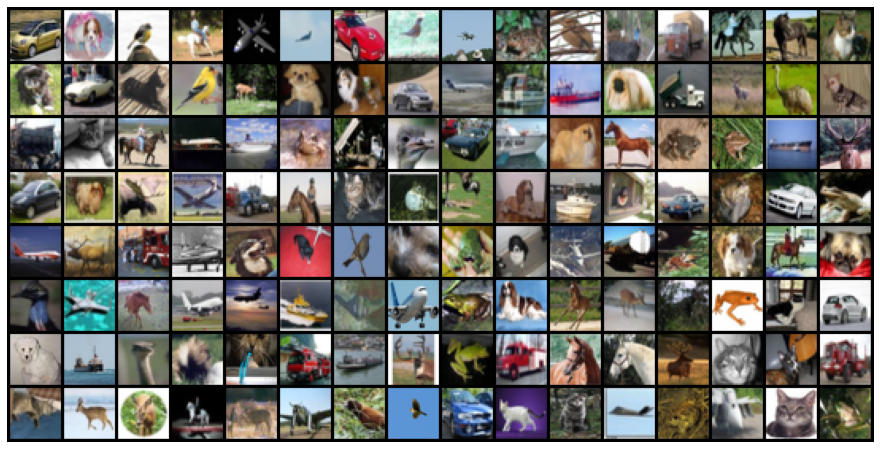

In [ ]:
transform = transforms.Compose([                                       
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip()
  ])
    

dataset = CIFAR10(root='data/', download=True, transform = transform)
test_dataset = CIFAR10(root='data/', train=False, transform = transform)

torch.manual_seed(43)

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, pin_memory=True)

for img, _ in train_loader:
      print('images.shape:', img.shape)
      plt.figure(figsize=(16,8))
      plt.axis('off')
      plt.imshow(make_grid(img, nrow=16).permute((1, 2, 0)))
      break

print(train_ds, val_ds)
print("len train horizontal flip", len(train_ds))

Files already downloaded and verified
images.shape: torch.Size([128, 3, 32, 32])
len train original 45000


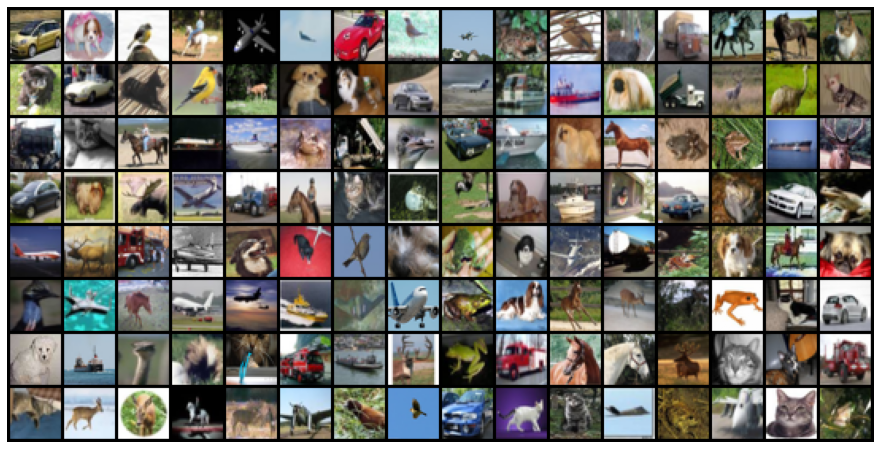

In [ ]:
transform = transforms.Compose([                                       
      transforms.ToTensor(),
  ])

dataset = CIFAR10(root='data/', download=True, transform = transform)
test_dataset = CIFAR10(root='data/', train=False, transform = transform)

torch.manual_seed(43)

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, pin_memory=True)

for img, _ in train_loader:
      print('images.shape:', img.shape)
      plt.figure(figsize=(16,8))
      plt.axis('off')
      plt.imshow(make_grid(img, nrow=16).permute((1, 2, 0)))
      break

print(train_ds, val_ds)
print("len train original", len(train_ds))

In [65]:
dataset = CIFAR10(root='data/', download=True, transform = transform)
test_dataset = CIFAR10(root='data/', train=False, transform = transform)

torch.manual_seed(43)
val_size = 5000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

Files already downloaded and verified


(45000, 5000)

In [19]:
data_array = dataset.data

In [20]:
data_array.shape

(50000, 32, 32, 3)

In [21]:
train_array = data_array[:-5000]
val_array = data_array[-5000:]

In [23]:
#normalize
train_array = train_array/255.0

In [24]:
#bright
import numpy as np
train_array2 = np.minimum(train_array*1.1,1)

In [25]:
#dark
import numpy as np
train_array3 = train_array*0.9

In [27]:
from torchvision.transforms.functional import rotate
tt = torch.tensor(train_array)
train_array4 = rotate(tt, 270).numpy()

In [49]:
train_array_combined = np.concatenate((train_array,train_array2,train_array3,train_array4), axis = 0)
train_array_combined = train_array_combined*2 - 1
print(train_array_combined.max(), train_array_combined.min())

1.0 -1.0


In [50]:
torch.tensor(train_array_combined, dtype = float).size()

torch.Size([180000, 32, 32, 3])

In [74]:
train_array_combined = np.transpose(train_array_combined, (0,3,1,2))

In [78]:
from torch.utils.data import TensorDataset
train_dataset_combined = TensorDataset(torch.tensor(train_array_combined, dtype = torch.float), torch.tensor(np.concatenate((dataset.targets[:-5000],dataset.targets[:-5000],dataset.targets[:-5000],dataset.targets[:-5000]))
,dtype = torch.long))

In [83]:
def train_neural_network(model,dataset_train,dataset_test,epochs,batch_size,
                         lr,activation,dev,assess):
  
  initial = 1
  stop = False
  valid_loss_final = []
  train_loss_final = []
  accuracy_final = []

  train_iterate = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_iterate = DataLoader(dataset_test, batch_size, num_workers=4, shuffle = True, pin_memory=True)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  while ((initial <= epochs) and (stop == False)):
    train_loss = 0

    for img, label in train_iterate:

      img = img.to(dev)

      label = label.to(dev)
      
      optimizer.zero_grad()

      output_img = model.forward(img)
      loss = activation(output_img, label)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss_final.append(train_loss/len(train_iterate))
    
    bss = len(train_iterate.dataset)/len(train_iterate)

    # print(len(train_iterate), "!!")
    # print(len(train_iterate.dataset), "##")
    # print(len(train_iterate.dataset)/len(train_iterate), "$$")

    with torch.no_grad():
      test_loss = 0
      for val_img, val_label in val_iterate:

        val_img = val_img.to(dev)
        val_label = val_label.to(dev)
        output_img = model.forward(val_img)
        loss = activation(output_img, val_label)
        accuracy = assess(val_label.cpu().numpy(), output_img.argmax(1).cpu().numpy())
        test_loss += loss.item()

      accuracy_final.append(accuracy)
      valid_loss_final.append(test_loss/len(val_iterate))
    

    print("Current_epoch: " +str(initial))
    print('Accuracy: '+str(accuracy))
    
    initial += 1 

  return valid_loss_final, accuracy_final

In [84]:
batch_size = 1024
epochs = 200
activation = nn.CrossEntropyLoss()
lr = 0.001

model_aug = CNN2DNet().to(dev)

model_aug.apply(weight_data)

valid_loss_aug, accuracy_aug = train_neural_network(model = model_aug, dataset_train = train_dataset_combined,
                dataset_test = val_ds, epochs = epochs,
                batch_size = batch_size, lr = lr,
                activation = activation, dev = dev,assess = accuracy_score)

Current_epoch: 1
Accuracy: 0.4424778761061947
Current_epoch: 2
Accuracy: 0.459070796460177
Current_epoch: 3
Accuracy: 0.49889380530973454
Current_epoch: 4
Accuracy: 0.5143805309734514
Current_epoch: 5
Accuracy: 0.5265486725663717
Current_epoch: 6
Accuracy: 0.5387168141592921
Current_epoch: 7
Accuracy: 0.5497787610619469
Current_epoch: 8
Accuracy: 0.5442477876106194
Current_epoch: 9
Accuracy: 0.5597345132743363
Current_epoch: 10
Accuracy: 0.5741150442477876
Current_epoch: 11
Accuracy: 0.5896017699115044
Current_epoch: 12
Accuracy: 0.5873893805309734
Current_epoch: 13
Accuracy: 0.5851769911504425
Current_epoch: 14
Accuracy: 0.5730088495575221
Current_epoch: 15
Accuracy: 0.6050884955752213
Current_epoch: 16
Accuracy: 0.6006637168141593
Current_epoch: 17
Accuracy: 0.5862831858407079
Current_epoch: 18
Accuracy: 0.5940265486725663
Current_epoch: 19
Accuracy: 0.5873893805309734
Current_epoch: 20
Accuracy: 0.581858407079646
Current_epoch: 21
Accuracy: 0.6028761061946902
Current_epoch: 22
Accur

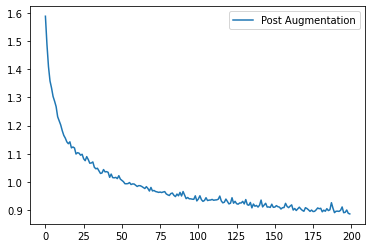

<Figure size 432x288 with 0 Axes>

In [85]:
plt.plot(valid_loss_aug, label = "Post Augmentation")
plt.legend()
plt.show()
plt.savefig("Valid_loss_after_aug.png")

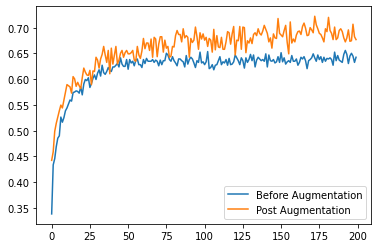

<Figure size 432x288 with 0 Axes>

In [93]:
plt.plot(accuracy_base, label = "Before Augmentation")
plt.plot(accuracy_aug, label = "Post Augmentation")
plt.legend()
plt.show()
plt.savefig("Accuracy_compare_aug.png")

# Question 2


In [88]:
class_0_transform = transforms.Compose([
    transforms.ToTensor()
    ])

class_0_data = CIFAR10(root='data/', download=True, train = True, transform=class_0_transform)

class_2_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=90, fill=0)
    ])

class_2_data = CIFAR10(root='data/', download=True, train = True, transform=class_2_transform)

class_1_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=1)
    ])

class_1_data = CIFAR10(root='data/', download=True, train = True, transform=class_1_transform)

train_data = ConcatDataset([class_0_data, class_1_data, class_2_data])

data_lis = list(range(0, len(train_data)))
a1 = 49500
a2 = 50000
a3 = 99500
a4 = 100000
a5 = 149500

updated_lis = data_lis[:a1] + data_lis[a2: a3] + data_lis[a4: a5]

test_data = CIFAR10(root='data/', download=True, train = False, transform=class_0_transform)
train_data_base = CIFAR10(root='data/', download=True, train = True, transform=class_0_transform)
data_lis_base = list(range(0, len(train_data_base)))
train_samples = data_lis_base[a1:]


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [74]:
units = 1024
output1 = 513

class CNN2DNet_Q2(nn.Module):
    def __init__(self):
      super(CNN2DNet_Q2, self).__init__()

      self.layer1 = nn.Conv2d(in_channels = 3, out_channels = 10, kernel_size = [5,5], stride = 1)
      self.maxpool1 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
      self.layer2 = nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = [5,5], stride = 1)
      self.maxpool2 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
     
      self.flatten = nn.Flatten(1)
      self.layer4 = nn.Linear(250, 20)
      self.layer5 = nn.Linear(20, 10)
    
    def forward(self, network):
      #print("input shape:", network.shape)
      # print(network.shape,  "#")
      network = self.layer1(network)
      network = F.relu(network)
      network = self.maxpool1(network)

      network = self.layer2(network)
      network = F.relu(network)
      network = self.maxpool2(network)


      network = self.flatten(network)

      network = self.layer4(network)
      network = F.relu(network)


      network = self.layer5(network)

      #print("out net shape:", network.shape)

      return network

input1 = 1024

def weight_data_Q2(m):
  if isinstance(m, nn.Linear):
        weight = torch.empty(input1, 1)
        torch.nn.init.kaiming_normal_(m.weight, a=0, nonlinearity='relu', mode='fan_in',)

In [75]:
def train_neural_network_Q2(model,dataset_train,dataset_test,epochs,batch_size,
                         lr,activation,dev, updated_lis,assess):
  
  initial = 1
  stop = False
  valid_loss_final = []
  train_loss_final = []
  accuracy_final = []
  
  train_iterate = dataset_train
  val_iterate = dataset_test
  
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  while ((initial <= epochs) and (stop == False)):
    train_loss = 0
    for img, label in train_iterate:

      img = img.to(dev)
      label = label.to(dev)
      
      optimizer.zero_grad()

      output_img = model.forward(img)
      loss = activation(output_img, label)
      #train_loss += loss.item()
      #optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss_final.append(train_loss/len(train_iterate))
    
    bss = len(train_iterate.dataset)/len(train_iterate)

    # print(len(train_iterate), "!!")
    # print(len(train_iterate.dataset), "##")
    # print(len(train_iterate.dataset)/len(train_iterate), "$$")

    with torch.no_grad():
      test_loss = 0
      for val_img, val_label in val_iterate:

        val_img = val_img.to(dev)
        val_label = val_label.to(dev)
        output_img = model.forward(val_img)
        loss = activation(output_img, val_label)
        accuracy = assess(val_label.cpu().numpy(), output_img.argmax(1).cpu().numpy())
        test_loss += loss.item()
  
      accuracy_final.append(accuracy)      
     
      valid_loss_final.append(test_loss/len(val_iterate))
      
      #valid_loss_final.append(performance/bss)

    torch.save(model.state_dict(), '/content/network-pretext.pt')

    print("Current_epoch: " +str(initial))
    print('Accuracy: '+str(accuracy))
    
    initial += 1 

  return valid_loss_final,accuracy_final

In [87]:
batch_size = 1024

train_iter = DataLoader(train_data, batch_size= batch_size, num_workers = 4, pin_memory=True, sampler= SubsetRandomSampler(updated_lis))

epochs = 100
activation = nn.CrossEntropyLoss()
lr = 0.001

model_Q2 = CNN2DNet_Q2().to(dev)

model_Q2.apply(weight_data_Q2)

valid_loss_2, accuracy_pretext = train_neural_network_Q2(model = model_Q2, dataset_train = train_iter,
                dataset_test = train_iter, epochs = epochs,
                batch_size = batch_size, lr = lr,
                activation = activation, dev = dev, updated_lis = updated_lis,assess = accuracy_score)


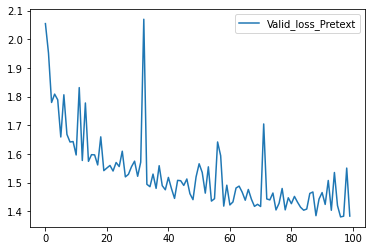

In [78]:
plt.plot(valid_loss_2, label = "Valid_loss_Pretext")
plt.legend()
plt.show()

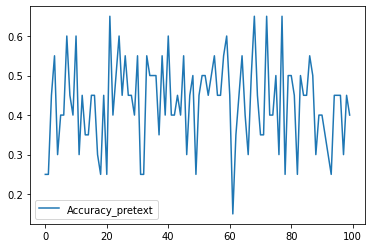

In [79]:
plt.plot(accuracy_pretext, label = "Accuracy_pretext")
plt.legend()
plt.show()

In [80]:
batch_size = 1024


train_iter_base = DataLoader(train_data_base, batch_size= batch_size, num_workers = 0, pin_memory=True, sampler= SubsetRandomSampler(train_samples))
test_iter_base = DataLoader(test_data, batch_size= batch_size, num_workers = 0, pin_memory=True)

epochs = 3000
activation = nn.CrossEntropyLoss()
lr = 0.001

model_Q2_base = CNN2DNet_Q2().to(dev)

model_Q2_base.apply(weight_data_Q2)

validd, accuracyy = train_neural_network_Q2(model = model_Q2_base, dataset_train = train_iter_base,
                dataset_test = test_iter_base, epochs = epochs,
                batch_size = batch_size, lr = lr,
                activation = activation, dev = dev, updated_lis = train_samples,assess = accuracy_score)


Streaming output truncated to the last 5000 lines.
Current_epoch: 501
Accuracy: 0.29209183673469385
Current_epoch: 502
Accuracy: 0.29464285714285715
Current_epoch: 503
Accuracy: 0.29336734693877553
Current_epoch: 504
Accuracy: 0.29081632653061223
Current_epoch: 505
Accuracy: 0.2895408163265306
Current_epoch: 506
Accuracy: 0.29464285714285715
Current_epoch: 507
Accuracy: 0.29464285714285715
Current_epoch: 508
Accuracy: 0.29209183673469385
Current_epoch: 509
Accuracy: 0.29209183673469385
Current_epoch: 510
Accuracy: 0.29209183673469385
Current_epoch: 511
Accuracy: 0.29336734693877553
Current_epoch: 512
Accuracy: 0.29336734693877553
Current_epoch: 513
Accuracy: 0.29081632653061223
Current_epoch: 514
Accuracy: 0.29081632653061223
Current_epoch: 515
Accuracy: 0.29209183673469385
Current_epoch: 516
Accuracy: 0.29336734693877553
Current_epoch: 517
Accuracy: 0.29209183673469385
Current_epoch: 518
Accuracy: 0.29081632653061223
Current_epoch: 519
Accuracy: 0.29464285714285715
Current_epoch: 520


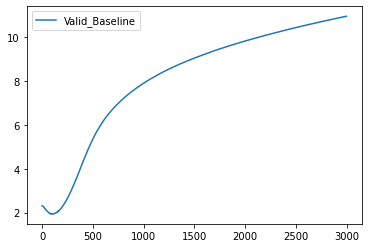

In [81]:
plt.plot(validd, label = "Valid_Baseline")
plt.legend()
plt.show()

In [83]:
def train_neural_network_transfer(model,dataset_train,dataset_test,epochs,batch_size,
                         lr,activation,dev,assess):
  
  initial = 1
  stop = False
  valid_loss_final = []
  train_loss_final = []
  accuracy_final = []
  
  train_iterate = dataset_train
  val_iterate = dataset_test

  optimizer = torch.optim.Adam([
         {"params": model.layer5.parameters(), "lr": 0.001}
        ], lr= 0.0001)

  while ((initial <= epochs) and (stop == False)):
    train_loss = 0
    for img, label in train_iterate:

      img = img.to(dev)
      label = label.to(dev)
      
      optimizer.zero_grad()

      output_img = model.forward(img)
      loss = activation(output_img, label)
      #train_loss += loss.item()
      #optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    train_loss_final.append(train_loss/len(train_iterate))
    
    bss = len(train_iterate.dataset)/len(train_iterate)

    # print(len(train_iterate), "!!")
    # print(len(train_iterate.dataset), "##")
    # print(len(train_iterate.dataset)/len(train_iterate), "$$")

    with torch.no_grad():
      test_loss = 0
      for val_img, val_label in val_iterate:

        val_img = val_img.to(dev)
        val_label = val_label.to(dev)
        output_img = model.forward(val_img)
        loss = activation(output_img, val_label)
        accuracy = assess(val_label.cpu().numpy(), output_img.argmax(1).cpu().numpy())
        test_loss += loss.item()
  
      accuracy_final.append(accuracy)
     
      valid_loss_final.append(test_loss/len(val_iterate))
      
      #valid_loss_final.append(performance/bss)

    

    print("Current_epoch: " +str(initial))
    print('Accuracy: '+str(accuracy))
    
    initial += 1 

  return valid_loss_final, accuracy_final

In [84]:
batch_size = 1024

epochs = 3000
activation = nn.CrossEntropyLoss()
lr = 0.001

model_Q2_transfer = CNN2DNet_Q2().to(dev)
model_Q2_transfer.load_state_dict(torch.load('/content/network-pretext.pt'), strict = False)

model_Q2_transfer.layer5 = nn.Linear(20,10)
model_Q2_transfer.apply(weight_data_Q2)
model_Q2_transfer.to(dev)

valid_Q2_transfer, acc = train_neural_network_transfer(model = model_Q2_transfer, dataset_train = train_iter_base,
                dataset_test = test_iter_base, epochs = epochs,
                batch_size = batch_size, lr = lr,
                activation = activation, dev = dev,assess = accuracy_score)


Streaming output truncated to the last 5000 lines.
Current_epoch: 501
Accuracy: 0.18877551020408162
Current_epoch: 502
Accuracy: 0.19005102040816327
Current_epoch: 503
Accuracy: 0.19005102040816327
Current_epoch: 504
Accuracy: 0.19005102040816327
Current_epoch: 505
Accuracy: 0.19005102040816327
Current_epoch: 506
Accuracy: 0.19005102040816327
Current_epoch: 507
Accuracy: 0.19005102040816327
Current_epoch: 508
Accuracy: 0.19005102040816327
Current_epoch: 509
Accuracy: 0.19005102040816327
Current_epoch: 510
Accuracy: 0.19260204081632654
Current_epoch: 511
Accuracy: 0.19260204081632654
Current_epoch: 512
Accuracy: 0.19260204081632654
Current_epoch: 513
Accuracy: 0.19260204081632654
Current_epoch: 514
Accuracy: 0.19260204081632654
Current_epoch: 515
Accuracy: 0.19387755102040816
Current_epoch: 516
Accuracy: 0.19387755102040816
Current_epoch: 517
Accuracy: 0.19387755102040816
Current_epoch: 518
Accuracy: 0.1951530612244898
Current_epoch: 519
Accuracy: 0.19642857142857142
Current_epoch: 520


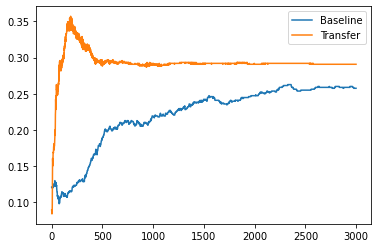

In [87]:
plt.plot(acc, label = "Baseline")
plt.plot(accuracyy, label = "Transfer")
plt.legend()
plt.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Question 3

In [89]:
train_trx_length = {}
N = 1200
path = '/content/drive/MyDrive/timit-homework/tr'
trx = "trx"
trs = "trs"
trn = "trn"
train_trx = []
train_main = []
train_trs = []
train_trn = []
common_path = "{}/{}{:04d}.wav"

for item in range(N):
  aud_trx,_ = librosa.load(common_path.format(path,trx,item), sr=None)
  aud_trx = librosa.stft(aud_trx, n_fft=1024, hop_length=512)
  aud_trx_abs = np.abs(aud_trx)
  shape_trx = aud_trx_abs.shape[1]
  train_trx_length[shape_trx] = train_trx_length.get(shape_trx,0)+1

  aud_trs,_ = librosa.load(common_path.format(path,trs,item), sr=None)
  aud_trs = librosa.stft(aud_trs, n_fft=1024, hop_length=512)
  aud_trs_abs = np.abs(aud_trs)
  aud_trn,_ =librosa.load(common_path.format(path,trn,item), sr=None)
  aud_trn = librosa.stft(aud_trn, n_fft=1024, hop_length=512)
  aud_trn_abs = np.abs(aud_trn)
  main = aud_trs_abs>aud_trn_abs
  main = 1*main
  mag_trx = np.transpose(aud_trx_abs)
  mag_trn = np.transpose(aud_trn_abs)
  mag_trs = np.transpose(aud_trs_abs)
  mag_main = np.transpose(main)
  train_trx.append(mag_trx)
  train_trs.append(mag_trs)
  train_trn.append(mag_trn)
  train_main.append(mag_main)

train_trx = sorted(train_trx, key=lambda item:len(item))
train_trs = sorted(train_trs, key=lambda item:len(item))
train_trn = sorted(train_trn, key=lambda item:len(item))
train_main = sorted(train_main, key=lambda item:len(item))

In [25]:
path = '/content/drive/MyDrive/timit-homework/v'
vx = "trx"
vs = "trs"
vn = "trn"
common_path = "{}/{}{:04d}.wav"
valid_vx = []
valid_main = []
valid_vs = []
valid_vn = []
valid_vx_length = {}
N = 500

for item in range(N):
  aud_vx,_ = librosa.load(common_path.format(path,vx,item), sr=None)
  aud_vx = librosa.stft(aud_vx, n_fft=1024, hop_length=512)
  aud_vx_abs = np.abs(aud_vx)
  shape_vx = aud_vx_abs.shape[1]
  valid_vx_length[shape_vx] = valid_vx_length.get(shape_vx,0)+1
  aud_vs,_ = librosa.load(common_path.format(path,vs,item), sr=None)
  aud_vs = librosa.stft(aud_vs, n_fft=1024, hop_length=512)
  aud_vs_abs = np.abs(aud_vs)
  aud_vn,_ =librosa.load(common_path.format(path,vn,item), sr=None)
  aud_vn = librosa.stft(aud_vn, n_fft=1024, hop_length=512)
  aud_vn_abs = np.abs(aud_vn)
  main_v = aud_vs_abs>aud_vn_abs
  main_v = 1*main_v
  mag_vx = np.transpose(aud_vx_abs)
  mag_vn = np.transpose(aud_vn_abs)
  mag_vs = np.transpose(aud_vs_abs)
  mag_main_v = np.transpose(main_v)

  valid_vx.append(mag_vx)
  valid_vs.append(mag_vs)
  valid_vn.append(mag_vn)
  valid_main.append(mag_main_v)

valid_vx = sorted(valid_vx,key=lambda item:len(item))
valid_vs = sorted(valid_vs,key=lambda item:len(item))
valid_vn = sorted(valid_vn,key=lambda item:len(item))
valid_main = sorted(valid_main,key=lambda item:len(item))


In [26]:
#https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

class CustomDataset():
    def __init__(self,X,y):
        self.dataset = X
        self.target = y

    def __getitem__(self,index):
        return self.dataset[index],self.target[index]

    def __len__(self):
        return len(self.dataset)

train_info = CustomDataset(train_trx,train_main)
val_info = CustomDataset(valid_vx,valid_main)
train_dataiter = DataLoader(train_info,10,shuffle=False)
val_dataiter = DataLoader(val_info,10)

In [28]:
from tqdm.notebook import tqdm

def acc_func(imag, truth):
    val = 0.5
    imag = imag > val
    y = (truth.size(0)*truth.size(1)*truth.size(2))
    x = (truth == imag).sum().item()
    acc = x/y
    return acc

def model_1(model, iter, opti):
    train_loss = 0
    train_accuracy = 0
    model.train()
    tqdm_tr = tqdm(iter,desc='Training')
    for img, batch in enumerate(tqdm_tr):
        batch_0 = batch[0]
        batch_1 = batch[1] 
        batch_0 = Variable(batch_0.type(torch.FloatTensor))
        target = Variable(batch_1.type(torch.FloatTensor))
        batch_0 = batch_0.to(dev)
        batch_1 = batch_1.to(dev)
        opti.zero_grad()
        imag = model(batch_0)
        acc = acc_func(imag,batch_1)
        activation = torch.nn.BCELoss(reduction='mean')
        loss = activation(imag, batch_1)
        loss.backward()
        opti.step()
        train_loss += loss.item()
        
        train_accuracy += acc
    return (train_loss/(img+1)),opti,(train_accuracy/(img+1))

def sav_file(name,train_loss,train_accuracy,epochs,model,opti):
    savee = {'epochs': epochs + 1,
             'opti': opti.state_dict(), 'state_dict': model.state_dict(), 
             'train_accuracy': train_accuracy, 
             'train_loss': train_loss,}
    torch.save(savee, name)

def model_2(model, iter):
    test_loss = 0
    test_accuracy = 0
    model.eval()

    with torch.no_grad():
        tqdm_v = tqdm(iter,desc='validation')
        for img, batch in enumerate():
            batch_0 = batch[0]
            batch_1 = batch[1] 
            batch_0 = Variable(batch_0.type(torch.FloatTensor))
            batch_1 = Variable(batch_1.type(torch.FloatTensor))
            batch_0 = batch_0.to(dev)
            batch_1 = batch_1.to(dev)
            imag = model(batch_0)
            activation = torch.nn.BCELoss(reduction='mean')
            loss = activation(imag, batch_1)
            acc = acc_func(imag,batch_1)
            test_loss += loss.item()
            test_accuracy += acc
    return (test_loss/(img+1)),(test_accuracy/(img+1))

In [90]:
class LSTM_RNN(nn.Module):
  
    def __init__(self):
        super(LSTM_RNN, self).__init__()
        self.layer1 = nn.LSTM(513,1024,batch_first=True, dropout = 0.2)
        self.layer2 = nn.Linear(1024,513)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, network,sigmoid=False):
        network,_ = self.layer1(network)
        network = self.relu(network)
        network = self.layer2(network)
        network = self.sigmoid(network)
        return network

In [30]:
from tqdm.notebook import tqdm

def rnn_train(model,val_dataset,lr,epochs,path_a, train_dataset):

    params = filter(lambda item: item.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(params,lr)

    for par in optimizer.param_groups:
        ini_lr =  par['lr'] = lr

    if not os.path.isdir(f'{path_a}'):
        os.makedirs(f'{path_a}')
        
    
    train_loss_fin = []
    train_acc_fin = []
    test_loss_fin = []
    test_acc_fin = []
    best_loss = float('inf')
    flag = 0
    coun = 2

    for epoch in range(epochs):        

        train_loss,opti,train_acc = model_1(model, train_dataset, optimizer)
        test_loss,test_acc = model_2(model, val_dataset)
        if test_loss < best_loss:
            best_loss = test_loss
            sav_file(path_a+'valid_loss_model.pth.tar',epoch,model,optimizer,train_loss,train_acc)
            flag = 0
        else:
            flag +=1       
        if flag > coun:
            value = torch.load(path_a+'valid_loss_model.pth.tar')
            model.load_state_dict(value['state_dict'])
            optimizer.load_state_dict(value['opti'])
            init_lr = init_lr/2
            for par in optimizer.param_groups:
                par['lr'] = init_lr
        if init_lr<0.00001:
            print("Early stopping")
            break
        sav_file(path_a+'current_model.pth.tar',epoch,model,optimizer,train_loss,train_acc)
        train_loss_fin.append(train_loss)
        test_loss_fin.append(test_loss)
        train_acc_fin.append(train_acc)
        test_acc_fin.append(test_acc)
        print('Epoch [{}/{}] Validation Loss: {:.8f}'.format(epoch+1, epochs,test_loss))
    return train_acc_fin,train_loss_fin,test_acc_fin,test_loss_fin

In [31]:
model_rnn = LSTM_RNN().to(dev)
lr = 0.001
epochs = 50
path_a = "/content/drive/MyDrive/timit-homework"
accuracies_train,losses_train,accuracies_test,losses_test = rnn_train(model = model_rnn, train_dataset = train_dataiter,val_dataset = val_dataiter, lr = lr, epochs = epochs,path_a = path_a)

Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50] Validation Loss: 0.60099465


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/50] Validation Loss: 0.53319552


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/50] Validation Loss: 0.48883550


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/50] Validation Loss: 0.46882441


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/50] Validation Loss: 0.44896330


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/50] Validation Loss: 0.43875009


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/50] Validation Loss: 0.42829428


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/50] Validation Loss: 0.42476155


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/50] Validation Loss: 0.41820128


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50] Validation Loss: 0.41122949


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/50] Validation Loss: 0.40697657


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/50] Validation Loss: 0.40699375


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/50] Validation Loss: 0.40435004


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/50] Validation Loss: 0.39851245


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/50] Validation Loss: 0.39578917


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/50] Validation Loss: 0.39355794


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/50] Validation Loss: 0.39372448


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/50] Validation Loss: 0.39243781


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/50] Validation Loss: 0.39493758


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/50] Validation Loss: 0.39744112


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/50] Validation Loss: 0.39729679


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/50] Validation Loss: 0.39025789


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/50] Validation Loss: 0.38741067


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/50] Validation Loss: 0.38801219


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/50] Validation Loss: 0.38720961


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/50] Validation Loss: 0.38859947


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/50] Validation Loss: 0.39184556


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/50] Validation Loss: 0.38947490


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/50] Validation Loss: 0.38844137


Training:   0%|          | 0/120 [00:00<?, ?it/s]

validation:   0%|          | 0/50 [00:00<?, ?it/s]

Early stopping


In [32]:
value = torch.load(path_a+'valid_loss_model.pth.tar')
model_rnn.load_state_dict(value['state_dict'])

<All keys matched successfully>

In [66]:
def clean_paths(path_list):
  cleaned_list = []
  for x in path_list:
    if " " in x:
      cleaned_list.append("/".join(x.split("/")[0:-1]) + "/" +x.split("/")[-1].split(".")[0].split(" ")[0]+".wav")
    else:
      cleaned_list.append(x)
  return cleaned_list

In [67]:
import glob
import re

model_rnn.eval()
paths = glob.glob("/content/drive/MyDrive/timit-homework/v/vx*")
paths = clean_paths(paths)
snr_value = []
val = 0.5

for fil in paths:
  # print(file_path)
  # if re.match('/content/drive/MyDrive/timit-homework/v/vs0005 (1).wav',file_path):
  #       continue
  # else:

    clean_fil,sr = librosa.load(fil.replace("x","s"), sr=None)
    
    fil_t, sr=librosa.load(fil, sr=None)
    stft_lib=librosa.stft(fil_t, hop_length=512, n_fft=1024)
    stft_lib_abs = np.abs(stft_lib)
    mag_stft = np.transpose(stft_lib_abs)
    tens_stft = torch.tensor(mag_stft)
    rnn_stft = model_rnn(tens_stft.unsqueeze(0).to(dev))
    rnn_stft = rnn_stft.squeeze(0).data.cpu().numpy()
    rnn_stft = 1 * (rnn_stft > val)
    mag_tr = np.transpose(rnn_stft)
    rnn_stft = mag_tr
    stft_2 = rnn_stft*stft_lib
    stft_2 = librosa.istft(stft_2, hop_length = 512, win_length = 1024)
    clean_main = clean_fil[0:stft_2.size]
    clean_tr = np.transpose(clean_main)
    x = np.dot(clean_tr,clean_main)
    y_2 = (clean_main - stft_2)
    y_1 = np.transpose(y_2)
    y = np.dot(y_1,y_2)
    snr = 10*np.log10(x/y)
    snr_value.append(snr)
print("Validation SNR")
np.sum(snr_value)/len(snr_value)

Validation SNR


9.999177124741605

In [72]:
import soundfile as sf
paths = glob.glob("/content/drive/MyDrive/timit-homework/te/tex*")
paths = clean_paths(paths)

for file in paths:
    name = file.split("tex")[-1]
    fil_t, sr=librosa.load(file, sr=None)
    stft_lib=librosa.stft(fil_t,hop_length=512, n_fft=1024)
    stft_lib_abs = np.abs(stft_lib)
    mag_stft = np.transpose(stft_lib_abs)
    tens_stft = torch.tensor(mag_stft)
    rnn_stft = model_rnn(tens_stft.unsqueeze(0).to(dev))
    rnn_stft = rnn_stft.squeeze(0).data.cpu().numpy()
    mag_tr = np.transpose(rnn_stft)
    stft_2 = (stft_lib/stft_lib_abs) * (mag_tr)
    main_istft = librosa.istft(stft_2,hop_length=512)

    sf.write(f'/content/drive/MyDrive/Output/{name}', main_istft, sr)

  # save_path = os.path.join("/content/drive/My Drive/output/",+str(sample)+'.wav')
  # sf.write(save_path, main_istft, sr)

In [97]:
import IPython
IPython.display.Audio("/content/drive/MyDrive/Output/0018.wav")